In [1]:
import numpy as np
import pandas as pd

# For calculation and solvinge quations/optimazation
import scipy.stats as ss
import scipy.optimize as scpo
from scipy import sparse
from scipy.fftpack import ifft
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from functools import partial

# Result Presenting
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import warnings; warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("BTC_options_maturity_fixed.csv",sep=",")

df = data[["Strike", "Bid", "Ask", "Type"]].copy()

df["Midpoint"] = (df["Bid"].astype(float) +df["Ask"].astype(float)) / 2
df["Spread"] = (df["Ask"].astype(float) -df["Bid"].astype(float)).round(6)
df["Type"]=df["Type"].map({"C": "Call", "P": "Put"})

df = df[["Strike", "Bid", "Midpoint", "Ask", "Type","Spread"]]
df = df.drop_duplicates()

df = df.sort_values(by=["Type", "Strike"]).reset_index(drop=True)

# Take mean price BTC/USD 
btc_usd = data["Prix actuel BTC"].astype(float).mean()

df["Bid"] =df["Bid"].astype(float) * btc_usd
df["Ask"] =df["Ask"].astype(float) * btc_usd
df["Midpoint"]=df["Midpoint"].astype(float) * btc_usd
df["Spread"] = (df["Ask"] - df["Bid"]).round(6)
df["Rel_Spread"] = (df["Spread"] /df["Midpoint"]).clip(lower=1e-6)
spreads = df["Rel_Spread"].values
print(df.head(5))
print(df.tail(5))
print(df.shape)

    Strike          Bid     Midpoint          Ask  Type      Spread  \
0  70000.0  8669.810523  8858.284665  9046.758806  Call  376.948284   
1  80000.0  2764.287413  2806.170556  2848.053698  Call   83.766285   
2  82000.0  2052.273988  2094.157131  2136.040274  Call   83.766285   
3  84000.0  1549.676277  1591.559420  1633.442562  Call   83.766285   
4  85000.0  1298.377421  1340.260564  1382.143707  Call   83.766285   

   Rel_Spread  
0    0.042553  
1    0.029851  
2    0.040000  
3    0.052632  
4    0.062500  
      Strike           Bid      Midpoint           Ask Type       Spread  \
59  115000.0  42343.857191  42720.805474  43097.753758  Put   753.896567   
60  130000.0  58720.165956  59159.938954  59599.711951  Put   879.545995   
61  135000.0  64290.623925  64709.455351  65128.286777  Put   837.662852   
62  150000.0  80708.815832  81190.471973  81672.128113  Put   963.312280   
63  160000.0  91640.316057  92184.796911  92729.277765  Put  1088.961708   

    Rel_Spread  
59 

In [3]:
class Diffusion_process():    
    def __init__(self, r=0.05, sig=0.2, mu=0.05):
        self.r, self.mu, self.sig = r, mu, sig

class Heston_process():
    def __init__(self, mu=0.05, rho=0, sigma=0.2, theta=0.04, kappa=2.5):
        self.mu, self.rho, self.theta, self.sigma, self.kappa = mu, rho, theta, sigma, kappa      

def fft(K, S0, r, T, cf):
    N = 2**15
    B = 500
    dx = B/N
    x = np.arange(N) * dx
    weight = 3 + (-1)**(np.arange(N)+1)
    weight[0] = 1
    weight[-1] = 1
    dk = 2*np.pi/B
    b = N * dk / 2
    ks = -b + dk * np.arange(N)
    integrand = np.exp(-1j * b * x) * cf(x - 0.5j) / (x**2 + 0.25) * weight * dx/3
    integral_value = np.real(ifft(integrand) * N)
    spline_cub = interp1d(ks, integral_value, kind="cubic")
    return S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_cub(np.log(S0/K))

class Option_param():  
    def __init__(self, S0=100, K=100, T=1, v0=0.04, payoff="call", exercise="European"):
        self.S0, self.v0, self.K, self.T, self.exercise, self.payoff = S0, v0, K, T, exercise, payoff

class Heston_pricer():
    def __init__(self, Option_info, Process_info ):
        self.r = Process_info.mu
        self.sigma = Process_info.sigma
        self.theta = Process_info.theta
        self.kappa = Process_info.kappa
        self.rho = Process_info.rho
        self.S0 = Option_info.S0
        self.v0 = Option_info.v0
        self.K = Option_info.K
        self.T = Option_info.T
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
    
    def FFT(self, K):
        K = np.array(K)
        def cf_Heston(u, t, v0, mu, kappa, theta, sigma, rho):
            xi = kappa - sigma*rho*u*1j
            d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j*u))
            g2 = (xi - d)/(xi + d)
            cf = np.exp(1j*u*mu*t + kappa*theta/sigma**2 * ((xi - d)*t - 2*np.log((1 - g2*np.exp(-d*t))/(1 - g2))) +
                        v0/sigma**2 * (xi - d) * (1 - np.exp(-d*t)) / (1 - g2*np.exp(-d*t)))
            return cf
        cf = partial(cf_Heston, t=self.T, v0=self.v0, mu=self.r, kappa=self.kappa,
                     theta=self.theta, sigma=self.sigma, rho=self.rho)
        if self.payoff == "call":
            return fft(K, self.S0, self.r, self.T, cf)
        else:
            return fft(K, self.S0, self.r, self.T, cf) - self.S0 + K*np.exp(-self.r*self.T)

def report_calibration(initial_guess, calibrated_params):
    report = pd.DataFrame({"Initial guess": initial_guess, "Calibrated": calibrated_params},
                          index=["rho", "sigma", "theta", "kappa", "v0"]).round(4).T
    return report


In [11]:
CALL = df[df.Type == "Call"].copy()
strikes = CALL.Strike.values
prices = CALL.Midpoint.values
spreads = CALL["Rel_Spread"].values
payoff = "call"

S0 = 83400
T = 18 / 365  # Ici maturité à 18 jours
r = 0.04

def f_Hest(K, rho, sigma, theta, kappa, v0):
    Heston_param = Heston_process(mu=r, rho=rho, sigma=sigma, theta=theta, kappa=kappa)
    opt_param = Option_param(S0=S0, K=S0, T=T, v0=v0, payoff=payoff)
    pricer = Heston_pricer(opt_param, Heston_param)
    return pricer.FFT(K)

init_vals = [-0.6, 1.0, 0.04, 2.5, 0.04] # rho, sigma, theta, kappa, v0
bounds = ( [-1, 1e-15, 1e-15, 1e-15, 1e-15], [1, np.inf, 2, np.inf, 2] )

params_Hest = scpo.curve_fit(f_Hest, strikes, prices, p0=init_vals,
                             bounds=bounds, sigma=spreads, max_nfev=10000)[0]

report = report_calibration(init_vals, params_Hest)
print(report)

               rho   sigma   theta   kappa     v0
Initial guess -0.6  1.0000  0.0400  2.5000  0.040
Calibrated     1.0  2.3617  0.2341  2.5503  0.058


In [12]:
# check the Feller condition
# 2*kappa*theta - sigma^2
2*2.5503*0.2341 - 2.3617**2

-4.38357643

In [5]:
class BS_pricer():
    """
    Finite-difference Black-Scholes PDE = df/dt + r df/dx + 1/2 sigma^2 d^f/dx^2 -rf = 0
    """
    def __init__(self, Option_info, Process_info ):
        """
        Process_info: a instance of "Diffusion_process.", which contains (r,mu, sig) 
        Option_info: of type Option_param, which contains (S0,K,T)
        """ 
        self.r = Process_info.r           # interest rate
        self.sig = Process_info.sig       # diffusion coefficient
        self.S0 = Option_info.S0          # current price
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity in years
        
        self.price = 0
        self.S_vec = None
        self.price_vec = None
        self.mesh = None
        self.exercise, self.payoff = Option_info.exercise, Option_info.payoff
        
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
        
    @staticmethod # Black Scholes closed formula
    def BlackScholes(payoff='call', S0=100., K=100., T=1., r=0.1, sigma=0.2 ):
        d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S0/K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        if payoff=="call":
            return S0 * ss.norm.cdf( d1 ) - K * np.exp(-r * T) * ss.norm.cdf( d2 )
        elif payoff=="put":
            return K * np.exp(-r * T) * ss.norm.cdf( -d2 ) - S0 * ss.norm.cdf( -d1 )
    
    # FFT method that yields a vector of prices.
    def FFT(self, K): # K: an array of strikes
        
        # Characteristic function of a Normal random variable
        def cf_normal(u, mu=1, sig=2):
            return np.exp( 1j * u * mu - 0.5 * u**2 * sig**2 )
        
        K = np.array(K)
        cf_GBM = partial(cf_normal, mu=( self.r - 0.5 * self.sig**2 )*self.T, sig=self.sig*np.sqrt(self.T))  # function binding
        if self.payoff == "call":
            return fft(K, self.S0, self.r, self.T, cf_GBM)
        elif self.payoff == "put":    # put-call parity
            return fft(K, self.S0, self.r, self.T, cf_GBM) - self.S0 + K*np.exp(-self.r*self.T)

In [6]:
K=S0

def Feller(x):
    return 2*x[3] * x[2] - x[1]**2 - 1e-6
cons = ({"fun": Feller, "type": "ineq"})

def least_sq(x, prices, strikes, spread):
    """ Objective function """
    Heston_param = Heston_process(mu=r, rho=x[0], sigma=x[1], theta=x[2], kappa=x[3])
    opt_param = Option_param(S0=S0, K=K, T=T, v0=x[4], exercise="European", payoff="call" )
    Hest = Heston_pricer(opt_param, Heston_param)
    prices_calib = Hest.FFT(strikes)
    return np.sum( ((prices_calib - prices)/spread)**2 ) 

init_vals = [-0.4, 1.1, 0.1, 0.6, 0.02] # rho, sigma, theta, kappa, v0
bounds = ( (-1,1), (1e-15,np.inf), (1e-15, 50), (1e-15, 50), (1e-15, 10) )
params_Hest_con = scpo.minimize(least_sq, x0=init_vals, args=(prices, strikes, spreads),
                  method='SLSQP', bounds=bounds,
                  constraints=cons, tol=1e-4, options={"maxiter":500}).x

# Result
report_calibration(init_vals, params_Hest_con)

def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BS.BlackScholes(payoff=payoff, S0=S0, K=K, T=T, r=r, sigma=vol) - price )**n
        
    res = scpo.minimize_scalar( obj_fun, bounds=(1e-14, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1

opt_param = Option_param(S0=S0, K=K, T=T, v0=params_Hest_con[4], exercise="European", payoff="call" )
diff_param = Diffusion_process(r=0.04, sig=0.2)
Heston_param = Heston_process(mu=0.04, rho=0, sigma=params_Hest_con[1], theta=params_Hest_con[2], kappa=params_Hest_con[3])

# Build the pricers
BS = BS_pricer(opt_param, diff_param)
Hest = Heston_pricer(opt_param, Heston_param)

# Compute the price
BS_prices = BS.FFT(strikes)
Hest_prices = Hest.FFT(strikes)
strikes = CALL.Strike.values

In [7]:
CALL["IV_mid"] = CALL.apply(lambda x: implied_vol_minimize(x['Midpoint'], S0, x['Strike'], T, r, payoff="call"), axis=1)
CALL = CALL.loc[CALL.IV_mid != -1,:].reset_index(drop=True) 
# When there is no implied volatility able to reproduce the mid-price, the function returns -1, we ignore these data points.
CALL

,Strike,Bid,Midpoint,Ask,Type,Spread,Rel_Spread,IV_mid
0,70000.0,8669.810523,8858.284665,9046.758806,Call,376.948284,0.042553,0.088440
1,80000.0,2764.287413,2806.170556,2848.053698,Call,83.766285,0.029851,0.019560
2,82000.0,2052.273988,2094.157131,2136.040274,Call,83.766285,0.040000,0.156911
3,84000.0,1549.676277,1591.559420,1633.442562,Call,83.766285,0.052632,0.243076
4,85000.0,1298.377421,1340.260564,1382.143707,Call,83.766285,0.062500,0.264986
5,86000.0,1130.844851,1151.786422,1172.727993,Call,41.883143,0.036364,0.287174
6,88000.0,795.779710,837.662852,879.545995,Call,83.766285,0.100000,0.321563
7,90000.0,586.363997,607.305568,628.247139,Call,41.883143,0.068966,0.349352
8,92000.0,418.831426,439.772998,460.714569,Call,41.883143,0.095238,0.372936
9,94000.0,309.935255,322.500198,335.065141,Call,25.129886,0.077922,0.394849


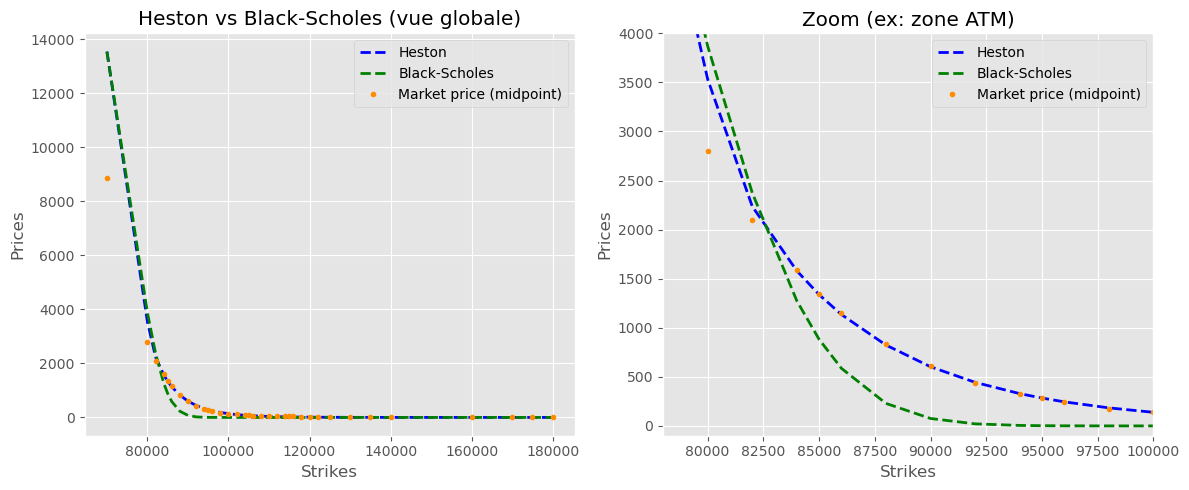

In [15]:

opt_param_BS = Option_param(S0=S0, K=K, T=T, payoff=payoff)
diff_param = Diffusion_process(r=r, sig=0.2)
BS_model = BS_pricer(opt_param_BS, diff_param)
BS_pred = BS_model.FFT(strikes)

opt_param_Hest = Option_param(S0=S0, K=K, T=T, v0=params_Hest[4], payoff=payoff)
Heston_param = Heston_process(mu=r, rho=params_Hest[0], sigma=params_Hest[1],theta=params_Hest[2], kappa=params_Hest[3])
Heston_model = Heston_pricer(opt_param_Hest, Heston_param)
Heston_pred = Heston_model.FFT(strikes)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(strikes, Heston_pred, label="Heston", color='blue',linestyle='--', linewidth=2)
ax1.plot(strikes, BS_pred, label="Black-Scholes", color='green', linestyle='--', linewidth=2)
ax1.plot(strikes, prices, 'o', label="Market price (midpoint)", color='darkorange', ms=3)
ax1.set_title("Heston vs Black-Scholes (vue globale)")
ax1.set_xlabel("Strikes")
ax1.set_ylabel("Prices")
ax1.legend()
ax1.grid(True)

ax2.plot(strikes, Heston_pred, label="Heston", color='blue', linestyle='--',linewidth=2)
ax2.plot(strikes, BS_pred, label="Black-Scholes", color='green', linestyle='--', linewidth=2)
ax2.plot(strikes, prices, 'o', label="Market price (midpoint)", color='darkorange', ms=3)
ax2.set_title("Zoom (ex: zone ATM)")
ax2.set_xlabel("Strikes")
ax2.set_ylabel("Prices")
ax2.set_xlim(78000, 100000)
ax2.set_ylim(-100, 4000)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


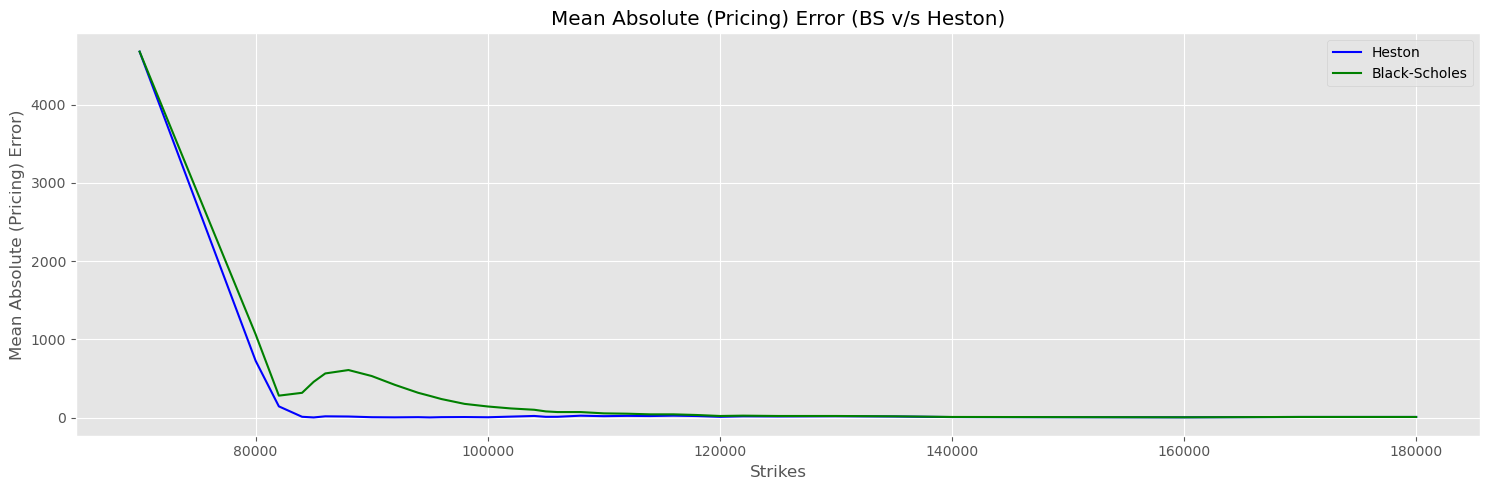

               Mean Absolute (Pricing) Error
Heston                              169.9412
Black-Scholes                       312.0516


In [9]:
# On s'assure que les prix sont tous positifs
Heston_pred[Heston_pred < 0] = 1e-8
BS_pred[BS_pred < 0] = 1e-8

# Graphe : Erreurs absolues de pricing
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(strikes, np.abs(prices - Heston_pred), label="Heston", color='blue')
ax.plot(strikes, np.abs(prices - BS_pred), label="Black-Scholes", color='green')
ax.set_title("Mean Absolute (Pricing) Error (BS v/s Heston)")
ax.set_xlabel("Strikes")
ax.set_ylabel("Mean Absolute (Pricing) Error)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Erreurs moyennes absolues
error_comparison = pd.DataFrame({
    "Heston": np.abs(prices - Heston_pred).mean(),
    "Black-Scholes": np.abs(prices - BS_pred).mean()
}, index=["Mean Absolute (Pricing) Error"]).round(4).T

print(error_comparison)


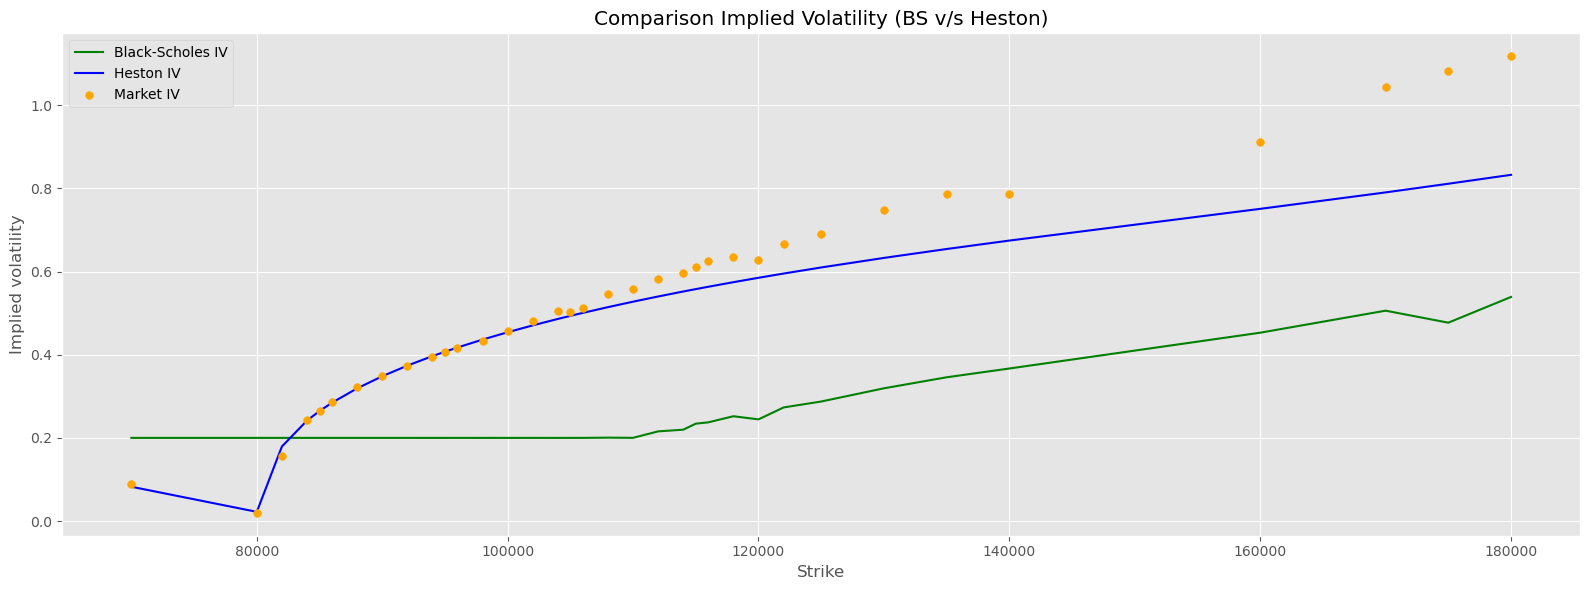

In [10]:
market_IV = [implied_vol_minimize(p, S0, K=k, T=T, r=r) for p, k in zip(prices, strikes)]

BS_compare = pd.DataFrame({"K": strikes, "BS_prices": BS_pred})
BS_compare["IV_BS_min"] = BS_compare.apply(lambda x: implied_vol_minimize(x["BS_prices"], S0, K=x["K"], T=T, r=r), axis=1)

Hest_compare = pd.DataFrame({"K": strikes, "Hest_prices": Heston_pred})
Hest_compare["IV_Hest_min"] = Hest_compare.apply(lambda x: implied_vol_minimize(x["Hest_prices"], S0, K=x["K"], T=T, r=r), axis=1)

IV_compare = pd.merge(BS_compare[["K", "IV_BS_min"]], Hest_compare[["K", "IV_Hest_min"]], on="K")
IV_compare["IV_Market"] = market_IV

plt.figure(figsize=(16, 6))

plt.plot(IV_compare["K"], IV_compare["IV_BS_min"], label="Black-Scholes IV", color='green', zorder=1)
plt.plot(IV_compare["K"], IV_compare["IV_Hest_min"], label="Heston IV", color='blue', zorder=1)

plt.scatter(IV_compare["K"], IV_compare["IV_Market"], label="Market IV", color='orange', s=30, zorder=2)

plt.title("Comparison Implied Volatility (BS v/s Heston)")
plt.xlabel("Strike")
plt.ylabel("Implied volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
